# Шаг 1. Генерация синтетических данных

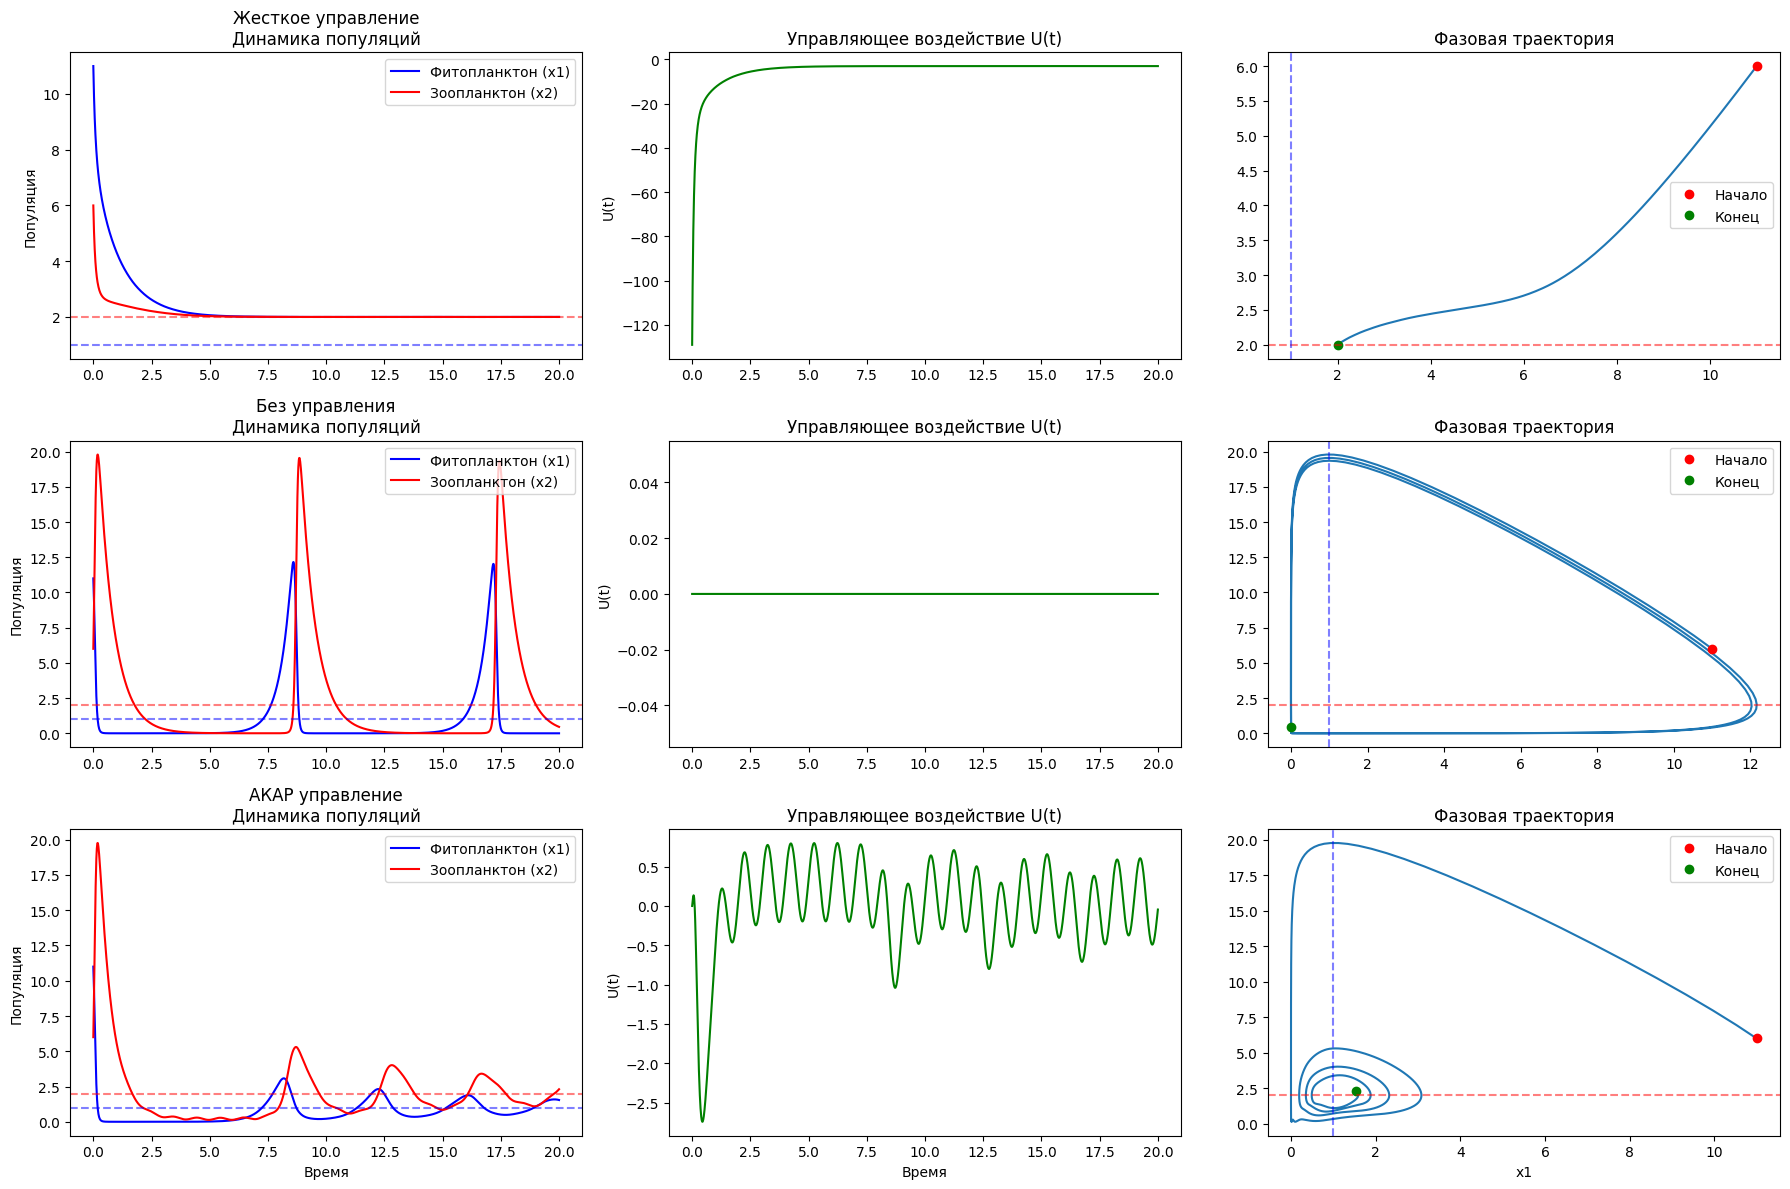

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Общие параметры системы
alpha1 = 2.0
beta1 = 1.0
alpha2 = 1.5
beta2 = 1.5
x1_target = 1.0
x2_target = 2.0
T2 = 1.0  # Параметр для жесткого управления

# Начальные условия и время
initial_conditions = [11.0, 6.0]
t_span = (0, 20)
t_eval = np.linspace(*t_span, 2000)

### 1. Система с жестким управлением 
def hard_control_system(t, z):
    x1, x2 = z
    # Жесткое управление 
    f1 = alpha1 * x1 - beta1 * x1 * x2
    f2_no_control = -alpha2 * x2 + beta2 * x1 * x2
    U = (1/T2) * (f1 - f2_no_control) - (1/T2) * (x2 - x1)
    dx1dt = alpha1 * x1 - beta1 * x1 * x2
    dx2dt = -alpha2 * x2 + beta2 * x1 * x2 + U
    return [dx1dt, dx2dt]

sol_hard = solve_ivp(hard_control_system, t_span, initial_conditions, t_eval=t_eval)
x1_hard, x2_hard = sol_hard.y
U_hard = [(1/T2) * (alpha1*x1 - beta1*x1*x2 - (-alpha2*x2 + beta2*x1*x2)) - (1/T2)*(x2 - x1) 
          for x1, x2 in zip(x1_hard, x2_hard)]

### 2. Система без управления (базовая модель Лотки-Вольтерры)
def no_control_system(t, z):
    x1, x2 = z
    dx1dt = alpha1 * x1 - beta1 * x1 * x2
    dx2dt = -alpha2 * x2 + beta2 * x1 * x2
    return [dx1dt, dx2dt]

sol_no = solve_ivp(no_control_system, t_span, initial_conditions, t_eval=t_eval)
x1_no, x2_no = sol_no.y

### 3. Система с АКАР
a = 0.5           # Амплитуда возбуждения
omega = 2 * np.pi # Частота возбуждения (1 Гц)
gamma = 0.1       # Скорость адаптации

def akar_system(t, z):
    x1, x2, K = z
    e = x2 - x2_target
    d = a * np.sin(omega * t)
    U = K * e + d      #  Управление зависит от ошибки
    dx1dt = alpha1 * x1 - beta1 * x1 * x2
    dx2dt = -alpha2 * x2 + beta2 * x1 * x2 + U
    dKdt = -gamma * e * d
    return [dx1dt, dx2dt, dKdt]

sol_akar = solve_ivp(akar_system, t_span, [*initial_conditions, 0.0], t_eval=t_eval)
x1_akar, x2_akar, K_akar = sol_akar.y
U_akar = [K * (x2 - x2_target) + a * np.sin(omega * t)
          for K, x2, t in zip(K_akar, x2_akar, sol_akar.t)]

### Визуализация всех трех систем
plt.figure(figsize=(18, 12))

# 1. Графики для жесткого управления
plt.subplot(3, 3, 1)
plt.plot(sol_hard.t, x1_hard, 'b', label='Фитопланктон (x1)')
plt.plot(sol_hard.t, x2_hard, 'r', label='Зоопланктон (x2)')
plt.axhline(x1_target, linestyle='--', color='b', alpha=0.5)
plt.axhline(x2_target, linestyle='--', color='r', alpha=0.5)
plt.title("Жесткое управление\nДинамика популяций")
plt.ylabel("Популяция")
plt.legend()

plt.subplot(3, 3, 2)
plt.plot(sol_hard.t, U_hard, 'g')
plt.title("Управляющее воздействие U(t)")
plt.ylabel("U(t)")

plt.subplot(3, 3, 3)
plt.plot(x1_hard, x2_hard)
plt.plot(x1_hard[0], x2_hard[0], 'ro', label='Начало')
plt.plot(x1_hard[-1], x2_hard[-1], 'go', label='Конец')
plt.axhline(x2_target, linestyle='--', color='r', alpha=0.5)
plt.axvline(x1_target, linestyle='--', color='b', alpha=0.5)
plt.title("Фазовая траектория")
plt.legend()

# 2. Графики для системы без управления
plt.subplot(3, 3, 4)
plt.plot(sol_no.t, x1_no, 'b', label='Фитопланктон (x1)')
plt.plot(sol_no.t, x2_no, 'r', label='Зоопланктон (x2)')
plt.axhline(x1_target, linestyle='--', color='b', alpha=0.5)
plt.axhline(x2_target, linestyle='--', color='r', alpha=0.5)
plt.title("Без управления\nДинамика популяций")
plt.ylabel("Популяция")
plt.legend()

plt.subplot(3, 3, 5)
plt.plot(sol_no.t, np.zeros_like(sol_no.t), 'g')  # Нет управления
plt.title("Управляющее воздействие U(t)")
plt.ylabel("U(t)")

plt.subplot(3, 3, 6)
plt.plot(x1_no, x2_no)
plt.plot(x1_no[0], x2_no[0], 'ro', label='Начало')
plt.plot(x1_no[-1], x2_no[-1], 'go', label='Конец')
plt.axhline(x2_target, linestyle='--', color='r', alpha=0.5)
plt.axvline(x1_target, linestyle='--', color='b', alpha=0.5)
plt.title("Фазовая траектория")
plt.legend()

# 3. Графики для системы с АКАР
plt.subplot(3, 3, 7)
plt.plot(sol_akar.t, x1_akar, 'b', label='Фитопланктон (x1)')
plt.plot(sol_akar.t, x2_akar, 'r', label='Зоопланктон (x2)')
plt.axhline(x1_target, linestyle='--', color='b', alpha=0.5)
plt.axhline(x2_target, linestyle='--', color='r', alpha=0.5)
plt.title("АКАР управление\nДинамика популяций")
plt.xlabel("Время")
plt.ylabel("Популяция")
plt.legend()

plt.subplot(3, 3, 8)
plt.plot(sol_akar.t, U_akar, 'g')
plt.title("Управляющее воздействие U(t)")
plt.xlabel("Время")
plt.ylabel("U(t)")

plt.subplot(3, 3, 9)
plt.plot(x1_akar, x2_akar)
plt.plot(x1_akar[0], x2_akar[0], 'ro', label='Начало')
plt.plot(x1_akar[-1], x2_akar[-1], 'go', label='Конец')
plt.axhline(x2_target, linestyle='--', color='r', alpha=0.5)
plt.axvline(x1_target, linestyle='--', color='b', alpha=0.5)
plt.title("Фазовая траектория")
plt.xlabel("x1")
plt.legend()

plt.tight_layout()
plt.show()


# Шаг 2.Проверка устойчивости по Ляпунову

Жесткое управление - собственные числа: [-1.00000000000000]
Без управления - собственные числа: [-1.73205080756888*I, 1.73205080756888*I]
АКАР управление - собственные числа: [-1.73205080756888*I, 1.73205080756888*I]

Упрощенные производные V':
Жесткое управление: -x1*(2*x1 - 2.0)*(1.0*x2 - 2.0) - (2*x2 - 4.0)*(1.0*x1*x2 - 3.0*x1 + 1.0*x2)
Без управления: -x1*(2*x1 - 2.0)*(1.0*x2 - 2.0) + 1.5*x2*(x1 - 1)*(2*x2 - 4.0)
АКАР: -x1*(2*x1 - 2.0)*(1.0*x2 - 2.0) + (2*x2 - 4.0)*(d + 1.5*x1*x2 - 1.5*x2)


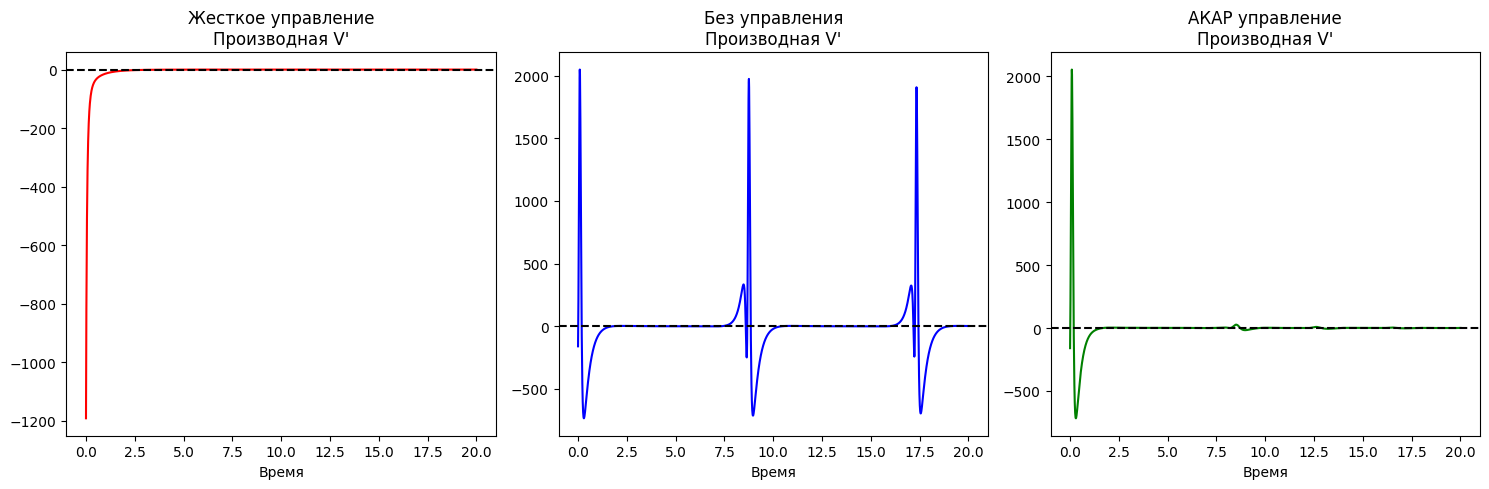


Проверка отрицательной определенности V':
Жесткое управление: False
Без управления: False
АКАР: False


In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from sympy import symbols, Matrix, simplify, diff, lambdify

# Общие параметры системы
alpha1 = 2.0
beta1 = 1.0
alpha2 = 1.5
beta2 = 1.5
x1_target = 1.0
x2_target = 2.0
T2 = 1.0  # Параметр для жесткого управления

# Символьные переменные
x1, x2 = symbols('x1 x2')
alpha1_sym, alpha2_sym, beta1_sym, beta2_sym, T2_sym, K_sym = symbols('alpha1 alpha2 beta1 beta2 T2 K')

### 1. Анализ для системы с жестким управлением
f1 = alpha1_sym*x1 - beta1_sym*x1*x2
f2_no_control = -alpha2_sym*x2 + beta2_sym*x1*x2
U_hard_sym = (1/T2_sym) * (f1 - f2_no_control) - (1/T2_sym) * (x2 - x1)
f2_hard = f2_no_control + U_hard_sym

# Матрица Якоби для жесткого управления
J_hard = Matrix([
    [diff(f1, x1), diff(f1, x2)],
    [diff(f2_hard, x1), diff(f2_hard, x2)]
])

# Подстановка параметров
J_hard_eval = J_hard.subs({
    alpha1_sym: alpha1,
    alpha2_sym: alpha2,
    beta1_sym: beta1,
    beta2_sym: beta2,
    T2_sym: T2,
    x1: x1_target,
    x2: x2_target
})

# Собственные числа
eigenvals_hard = J_hard_eval.eigenvals()
print("Жесткое управление - собственные числа:", list(eigenvals_hard.keys()))

### 2. Анализ для системы без управления
f2_no = f2_no_control  # Без управления U=0

# Матрица Якоби без управления
J_no = Matrix([
    [diff(f1, x1), diff(f1, x2)],
    [diff(f2_no, x1), diff(f2_no, x2)]
])

J_no_eval = J_no.subs({
    alpha1_sym: alpha1,
    alpha2_sym: alpha2,
    beta1_sym: beta1,
    beta2_sym: beta2,
    x1: x1_target,
    x2: x2_target
})

eigenvals_no = J_no_eval.eigenvals()
print("Без управления - собственные числа:", list(eigenvals_no.keys()))

### 3. Анализ для системы с АКАР
a = 0.5
omega = 2*np.pi
d_sym = symbols('d')  # Символьное представление возмущения
U_akar_sym = K_sym * (x2 - x2_target) + d_sym
f2_akar = f2_no_control + U_akar_sym

# Матрица Якоби для АКАР (упрощенная, без учета адаптации K)
J_akar = Matrix([
    [diff(f1, x1), diff(f1, x2)],
    [diff(f2_akar, x1), diff(f2_akar, x2)]
])

J_akar_eval = J_akar.subs({
    alpha1_sym: alpha1,
    alpha2_sym: alpha2,
    beta1_sym: beta1,
    beta2_sym: beta2,
    x1: x1_target,
    x2: x2_target,
    K_sym: 0  # Анализ в точке равновесия
})

eigenvals_akar = J_akar_eval.eigenvals()
print("АКАР управление - собственные числа:", list(eigenvals_akar.keys()))

### Функции Ляпунова для всех систем
V = (x1 - x1_target)**2 + (x2 - x2_target)**2
dV_dx1 = diff(V, x1)
dV_dx2 = diff(V, x2)

# Производные для каждого случая
V_dot_hard = dV_dx1*f1 + dV_dx2*f2_hard
V_dot_no = dV_dx1*f1 + dV_dx2*f2_no
V_dot_akar = dV_dx1*f1 + dV_dx2*f2_akar

# Упрощенные выражения
V_dot_hard_simplified = simplify(V_dot_hard.subs({
    alpha1_sym: alpha1, alpha2_sym: alpha2,
    beta1_sym: beta1, beta2_sym: beta2,
    T2_sym: T2
}))

V_dot_no_simplified = simplify(V_dot_no.subs({
    alpha1_sym: alpha1, alpha2_sym: alpha2,
    beta1_sym: beta1, beta2_sym: beta2
}))

V_dot_akar_simplified = simplify(V_dot_akar.subs({
    alpha1_sym: alpha1, alpha2_sym: alpha2,
    beta1_sym: beta1, beta2_sym: beta2,
    K_sym: 0  # Для анализа в равновесии
}))

print("\nУпрощенные производные V':")
print(f"Жесткое управление: {V_dot_hard_simplified}")
print(f"Без управления: {V_dot_no_simplified}")
print(f"АКАР: {V_dot_akar_simplified}")

### Численная проверка производных вдоль траекторий


# Создаем функции для численной оценки
V_dot_hard_func = lambdify((x1, x2), V_dot_hard_simplified, 'numpy')
V_dot_no_func = lambdify((x1, x2), V_dot_no_simplified, 'numpy')
V_dot_akar_func = lambdify((x1, x2, K_sym, d_sym), V_dot_akar_simplified, 'numpy')  

# Вычисляем значения производных
V_dot_hard_values = [V_dot_hard_func(x1, x2) for x1, x2 in zip(x1_hard, x2_hard)]
V_dot_no_values = [V_dot_no_func(x1, x2) for x1, x2 in zip(x1_no, x2_no)]
V_dot_akar_values = [V_dot_akar_func(x1, x2, K, a*np.sin(omega*t)) 
                    for x1, x2, K, t in zip(x1_akar, x2_akar, K_akar, sol_akar.t)]  
# Визуализация
plt.figure(figsize=(15, 5))

# Жесткое управление
plt.subplot(1, 3, 1)
V_dot_hard_values = [V_dot_hard_func(x1, x2) for x1, x2 in zip(x1_hard, x2_hard)]
plt.plot(sol_hard.t, V_dot_hard_values, 'r')
plt.axhline(0, color='k', linestyle='--')
plt.title("Жесткое управление\nПроизводная V'")
plt.xlabel('Время')

# Без управления
plt.subplot(1, 3, 2)
V_dot_no_values = [V_dot_no_func(x1, x2) for x1, x2 in zip(x1_no, x2_no)]
plt.plot(sol_no.t, V_dot_no_values, 'b')
plt.axhline(0, color='k', linestyle='--')
plt.title("Без управления\nПроизводная V'")
plt.xlabel('Время')

# АКАР
plt.subplot(1, 3, 3)
V_dot_akar_values = [V_dot_akar_func(x1, x2, K, 0) for x1, x2, K in zip(x1_akar, x2_akar, K_akar)]
plt.plot(sol_akar.t, V_dot_akar_values, 'g')
plt.axhline(0, color='k', linestyle='--')
plt.title("АКАР управление\nПроизводная V'")
plt.xlabel('Время')

plt.tight_layout()
plt.show()

# Проверка отрицательной определенности
print("\nПроверка отрицательной определенности V':")
print(f"Жесткое управление: {all(v <= 0 for v in V_dot_hard_values)}")
print(f"Без управления: {all(v <= 0 for v in V_dot_no_values)}")
print(f"АКАР: {all(v <= 0 for v in V_dot_akar_values)}")